In [9]:
import pandas as pd
import numpy as np
import pandas_datareader as pdr
import matplotlib.pyplot as plt
import requests 
import eia
import os
import datetime
import json
import requests
import quandl
import plotly.express as px
import panel as pn
from panel.interact import interact
from panel import widgets
from pathlib import Path
import matplotlib.pyplot as plts
import hvplot.pandas 
pn.extension("plotly")

In [10]:
import pandas_datareader as pdr
import matplotlib.pyplot as plt
#Trade data for West Texas Intermediate 
oil_data = pdr.get_data_yahoo('cl=f', '2-March-19') 
oil_data.tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2020-07-05,40.529999,40.200001,40.310001,40.400002,280157.0,40.400002
2020-07-06,41.080002,40.150002,40.509998,40.700001,120009324.0,40.700001
2020-07-07,40.950001,39.900002,40.490002,40.400002,102966911.0,40.400002
2020-07-08,41.080002,40.330002,40.529999,40.939999,107804456.0,40.939999
2020-07-09,40.939999,39.270000,40.840000,39.590000,136314574.0,39.590000


In [11]:
#Moving average crossover strategy
oil_data['9_SMA'] = oil_data['Close'].rolling(window=9).mean()
oil_data['20_SMA'] = oil_data['Close'].rolling(window=50).mean()

oil_data = oil_data[oil_data['20_SMA'].notna()]

# MA trade calls
Trade_Buy=[]
Trade_Sell=[]
for i in range(len(oil_data)-1):
    if ((oil_data['9_SMA'].values[i] < oil_data['20_SMA'].values[i]) & (oil_data['9_SMA'].values[i+1] > oil_data['20_SMA'].values[i+1])):
        print("Trade Call for {row} is Buy.".format(row=oil_data.index[i].date()))
        Trade_Buy.append(i)
    elif ((oil_data['9_SMA'].values[i] > oil_data['20_SMA'].values[i]) & (oil_data['9_SMA'].values[i+1] < oil_data['20_SMA'].values[i+1])):
        print("Trade Call for {row} is Sell.".format(row=oil_data.index[i].date()))
        Trade_Sell.append(i)

Trade Call for 2019-05-22 is Sell.
Trade Call for 2019-07-09 is Buy.
Trade Call for 2019-07-23 is Sell.
Trade Call for 2019-08-01 is Buy.
Trade Call for 2019-08-02 is Sell.
Trade Call for 2019-09-10 is Buy.
Trade Call for 2019-09-11 is Sell.
Trade Call for 2019-09-13 is Buy.
Trade Call for 2019-10-02 is Sell.
Trade Call for 2019-10-31 is Buy.
Trade Call for 2020-01-17 is Sell.
Trade Call for 2020-05-10 is Buy.


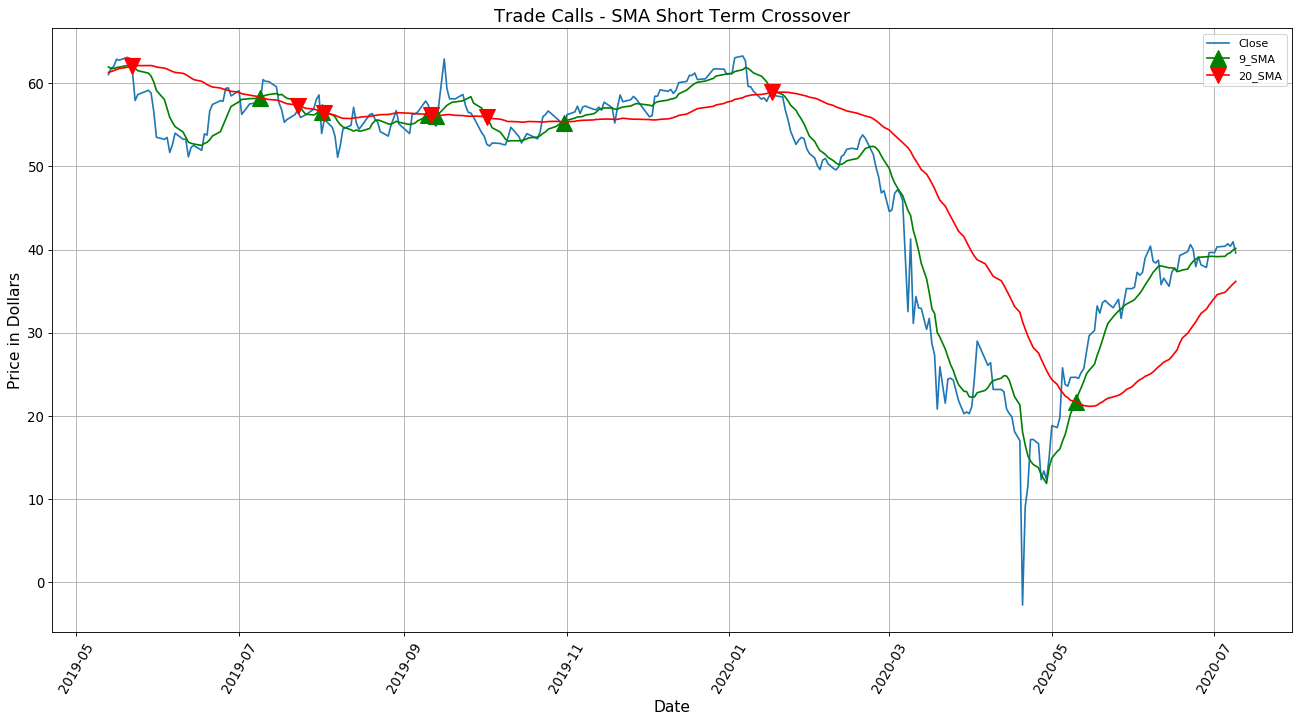

In [14]:
plts.figure(figsize=(20, 10),dpi=80)
plts.plot(oil_data.index, oil_data['Close'])
plts.plot(oil_data.index, oil_data['9_SMA'],'-^', markevery=Trade_Buy, ms=15, color='green')
plts.plot(oil_data.index, oil_data['20_SMA'],'-v', markevery=Trade_Sell, ms=15, color='red')
plts.xlabel('Date',fontsize=14)
plts.ylabel('Price in Dollars', fontsize = 14)
plts.xticks(rotation='60',fontsize=12)
plts.yticks(fontsize=12)
plts.title('Trade Calls - SMA Short Term Crossover', fontsize = 16)
plts.legend(['Close','9_SMA','20_SMA'])
plts.grid()
plts.show() 

In [17]:
#NEWS TRADING STRATEGY 
# News API
url = 'https://newsapi.org/v2/everything?'

# Parameters
parameters = {
    'q': 'WTI', # query phrase
    'sortBy': 'popularity', # articles from popular sources and publishers come first
    'pageSize': 100,  # maximum is 100 for developer version
    'apiKey': '41f82539f4ec4ba79932a9ce234f115a', # your own API key
}

# API request
response = requests.get(url, params=parameters)

# Convert the response to JSON format and store it in dataframe
data = pd.DataFrame(response.json())

news_df = pd.concat([data['articles'].apply(pd.Series)], axis=1)

oil_news = news_df.loc[:,['publishedAt','title']]
oil_news['publishedAt'] = pd.to_datetime(oil_news['publishedAt'])
oil_news.sort_values(by='publishedAt',inplace=True)

# Business day dates
from pandas.tseries.offsets import BDay
# to get the business day for which particular news headline should be used to make trade calls
def get_trade_open(date):
    curr_date_open = pd.to_datetime(date).floor('d').replace(hour=13,minute=30) - BDay(0)
    curr_date_close = pd.to_datetime(date).floor('d').replace(hour=20,minute=0) - BDay(0)
    
    prev_date_close = (curr_date_open - BDay()).replace(hour=20,minute=0)
    next_date_open = (curr_date_close + BDay()).replace(hour=13,minute=30)
    
    if ((pd.to_datetime(date)>=prev_date_close) & (pd.to_datetime(date)<curr_date_open)):
        return curr_date_open
    elif ((pd.to_datetime(date)>=curr_date_close) & (pd.to_datetime(date)<next_date_open)):
        return next_date_open
    else:
        return None
      
 # Trading time for news headlines
oil_news["trading_time"] = oil_news["publishedAt"].apply(get_trade_open)

oil_news = oil_news[pd.notnull(oil_news['trading_time'])]
oil_news['Date'] = pd.to_datetime(pd.to_datetime(oil_news['trading_time']).dt.date)

In [18]:
#NLTK Imports
from nltk.sentiment.vader import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()

In [19]:
cs = []
for row in range(len(oil_news)):
    cs.append(analyzer.polarity_scores(oil_news['title'].iloc[row])['compound'])

oil_news['compound_vader_score'] = cs
oil_news = oil_news[(oil_news[['compound_vader_score']] != 0).all(axis=1)].reset_index(drop=True)

oil_news.tail()

,publishedAt,title,trading_time,Date,compound_vader_score
51,2020-07-08 12:53:00+00:00,GLOBAL MARKETS-Global shares waver on coronavi...,2020-07-08 13:30:00+00:00,2020-07-08,-0.1531
52,2020-07-09 00:55:00+00:00,Oil prices idle as coronavirus spike fears off...,2020-07-09 13:30:00+00:00,2020-07-09,-0.4215
53,2020-07-09 02:41:00+00:00,Oil eases as coronavirus fears offset gasoline...,2020-07-09 13:30:00+00:00,2020-07-09,-0.1280
54,2020-07-09 05:04:00+00:00,UPDATE 2-Oil steady as coronavirus fears offse...,2020-07-09 13:30:00+00:00,2020-07-09,-0.4215
55,2020-07-09 08:37:00+00:00,Oil slips as coronavirus fears offset gasoline...,2020-07-09 13:30:00+00:00,2020-07-09,-0.4215


In [20]:
unique_dates = oil_news['Date'].unique()
grouped_dates = oil_news.groupby(['Date'])
keys_dates = list(grouped_dates.groups.keys())

max_cs = []
min_cs = []

for key in grouped_dates.groups.keys():
    data = grouped_dates.get_group(key)
    if data["compound_vader_score"].max() > 0:
        max_cs.append(data["compound_vader_score"].max())
    elif data["compound_vader_score"].max() < 0:
        max_cs.append(0)
    
    if data["compound_vader_score"].min() < 0:
        min_cs.append(data["compound_vader_score"].min())
    elif data["compound_vader_score"].min() > 0:
        min_cs.append(0)
    
extreme_scores_dict = {'Date':keys_dates,'max_scores':max_cs,'min_scores':min_cs}
extreme_scores_df = pd.DataFrame(extreme_scores_dict)

In [21]:
final_scores = []
for i in range(len(extreme_scores_df)):
    final_scores.append(extreme_scores_df['max_scores'].values[i] + extreme_scores_df['min_scores'].values[i])

extreme_scores_df['final_scores'] = final_scores

extreme_scores_df.head()

,Date,max_scores,min_scores,final_scores
0,2020-06-09,0.0000,-0.6249,-0.6249
1,2020-06-10,0.0000,-0.5574,-0.5574
2,2020-06-11,0.0000,-0.7845,-0.7845
3,2020-06-12,0.0000,-0.3182,-0.3182
4,2020-06-18,0.0258,-0.6705,-0.6447


In [22]:
# VADER trade calls
vader_Buy=[]
vader_Sell=[]
for i in range(len(extreme_scores_df)):
    if extreme_scores_df['final_scores'].values[i] > 0.20:
        print("Trade Call for {row} is Buy.".format(row=extreme_scores_df['Date'].iloc[i].date()))
        vader_Buy.append(extreme_scores_df['Date'].iloc[i].date())
    elif extreme_scores_df['final_scores'].values[i] < -0.20:
        print("Trade Call for {row} is Sell.".format(row=extreme_scores_df['Date'].iloc[i].date()))
        vader_Sell.append(extreme_scores_df['Date'].iloc[i].date())

Trade Call for 2020-06-09 is Sell.
Trade Call for 2020-06-10 is Sell.
Trade Call for 2020-06-11 is Sell.
Trade Call for 2020-06-12 is Sell.
Trade Call for 2020-06-18 is Sell.
Trade Call for 2020-06-19 is Buy.
Trade Call for 2020-06-24 is Sell.
Trade Call for 2020-06-25 is Sell.
Trade Call for 2020-06-26 is Sell.
Trade Call for 2020-06-30 is Sell.
Trade Call for 2020-07-02 is Sell.
Trade Call for 2020-07-03 is Sell.
Trade Call for 2020-07-07 is Buy.
Trade Call for 2020-07-09 is Sell.


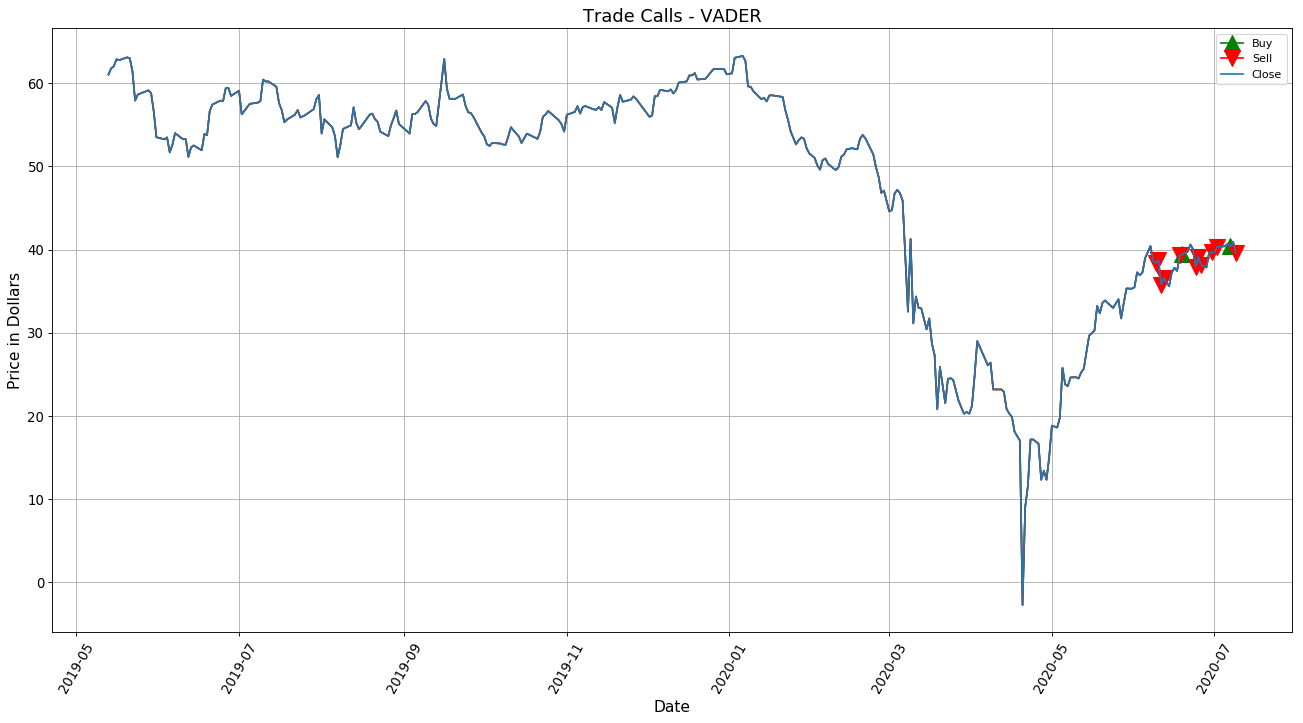

In [23]:
vader_buy = []
for i in range(len(oil_data)):
    if oil_data.index[i].date() in vader_Buy:
        vader_buy.append(i)
        
vader_sell = []
for i in range(len(oil_data)):
    if oil_data.index[i].date() in vader_Sell:
        vader_sell.append(i)
        
plts.figure(figsize=(20, 10),dpi=80)
plts.plot(oil_data.index, oil_data['Close'],'-^', markevery=vader_buy, ms=15, color='green')
plts.plot(oil_data.index, oil_data['Close'],'-v', markevery=vader_sell, ms=15, color='red')
plts.plot(oil_data.index, oil_data['Close'])
plts.xlabel('Date',fontsize=14)
plts.ylabel('Price in Dollars', fontsize = 14)
plts.xticks(rotation='60',fontsize=12)
plts.yticks(fontsize=12)
plts.title('Trade Calls - VADER', fontsize = 16)
plts.legend(['Buy','Sell','Close'])
plts.grid()
plts.show()

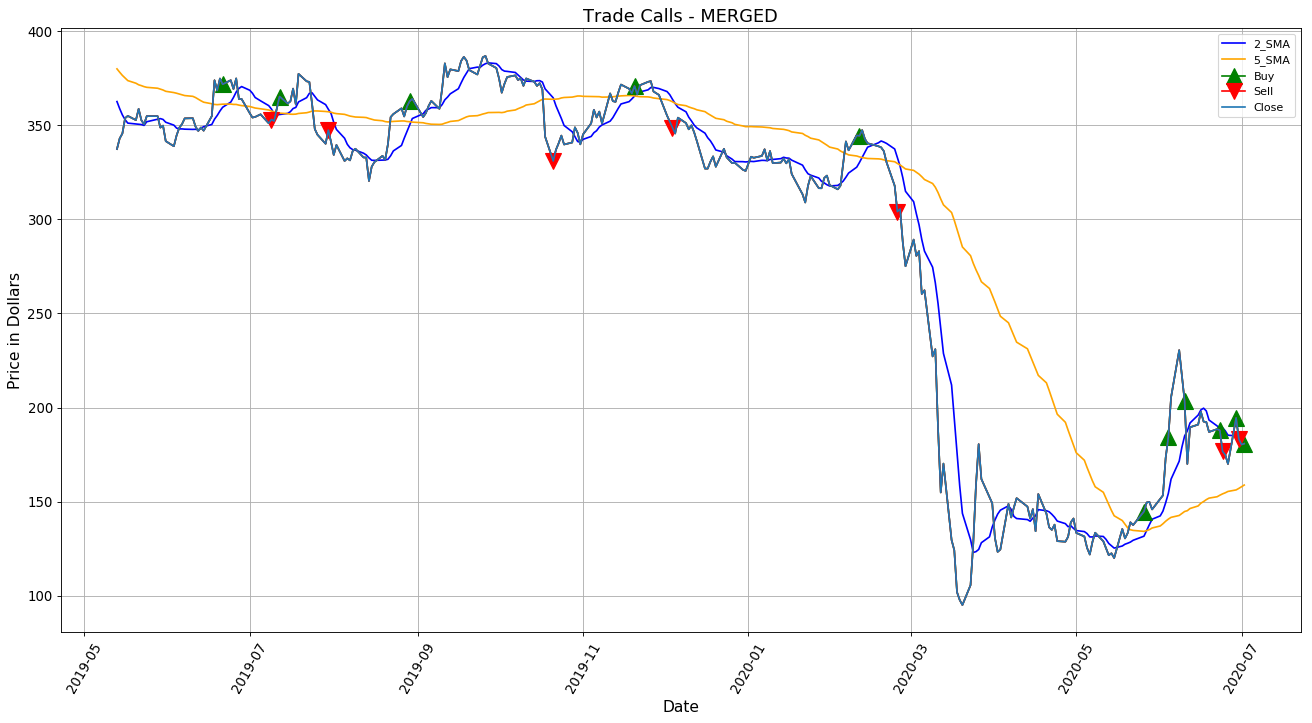

In [69]:
#SMA signals
final_buy = list(set(Trade_Buy + vader_buy) - set(Trade_Sell)) 
final_sell = list(set(Trade_Sell + vader_sell) - set(Trade_Buy))

plt.figure(figsize=(20, 10),dpi=80)
plt.plot(data_ba.index, data_ba['9_SMA'], color='blue')
plt.plot(data_ba.index, data_ba['50_SMA'], color='orange')
plt.plot(data_ba.index, data_ba['Close'],'-^', markevery=final_buy, ms=15, color='green')
plt.plot(data_ba.index, data_ba['Close'],'-v', markevery=final_sell, ms=15, color='red')
plt.plot(data_ba.index, data_ba['Close'])
plt.xlabel('Date',fontsize=14)
plt.ylabel('Price in Dollars', fontsize = 14)
plt.xticks(rotation='60',fontsize=12)
plt.yticks(fontsize=12)
plt.title('Trade Calls - MERGED', fontsize = 16)
plt.legend(['2_SMA','5_SMA','Buy','Sell','Close'])
plt.grid()
plt.show()